# Step 4: Feature Correlation
In this notebook, we assess the importance of different features using the American Community Survey (ACS) estimate data as features and the overall childhood opportunity index as the target. We identify 56 of 119 features that are more than 80% correlated and remove those features from the dataset.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import io, s3fs, json, traceback
pd.set_option('display.max_columns', None)
print('Program run at', dt.now())

Program run at 2021-06-26 09:00:57.933121


In [2]:
#read in the estimate data with the overall COI as the target
est = pd.read_csv('s3://bleeding-hearts/workingdata/est_overall.csv')
est.drop(columns=['Unnamed: 0'],inplace=True)
est.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 120 entries, EMPLOYMENT STATUS_Population 16 years and over to Child Opportunity Levels, overall COI, nationally-normed
dtypes: float64(118), int64(1), object(1)
memory usage: 16.7+ MB


In [3]:
#impute mean values for missing values
means = {}
cols=list(est)
for c in cols:
    if len(est) - est[c].count() > 0:
        means[c] = est[c].dropna().mean()
est.fillna(value=means,inplace=True)
#check that there are no more missing values
est.columns[est.isnull().any()]

Index([], dtype='object')

In [4]:
#make label lists
cat_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

In [5]:
from pandas import plotting
import matplotlib.pyplot as plt

# Ignore warnings from scikit-learn to make this notebook a bit nicer
import warnings
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance
from sklearn.utils import resample

from sklearn.model_selection import train_test_split as tts
from sklearn.impute import SimpleImputer

## Feature importance - all ACS features
First we ran feature importance for all the ACS features.

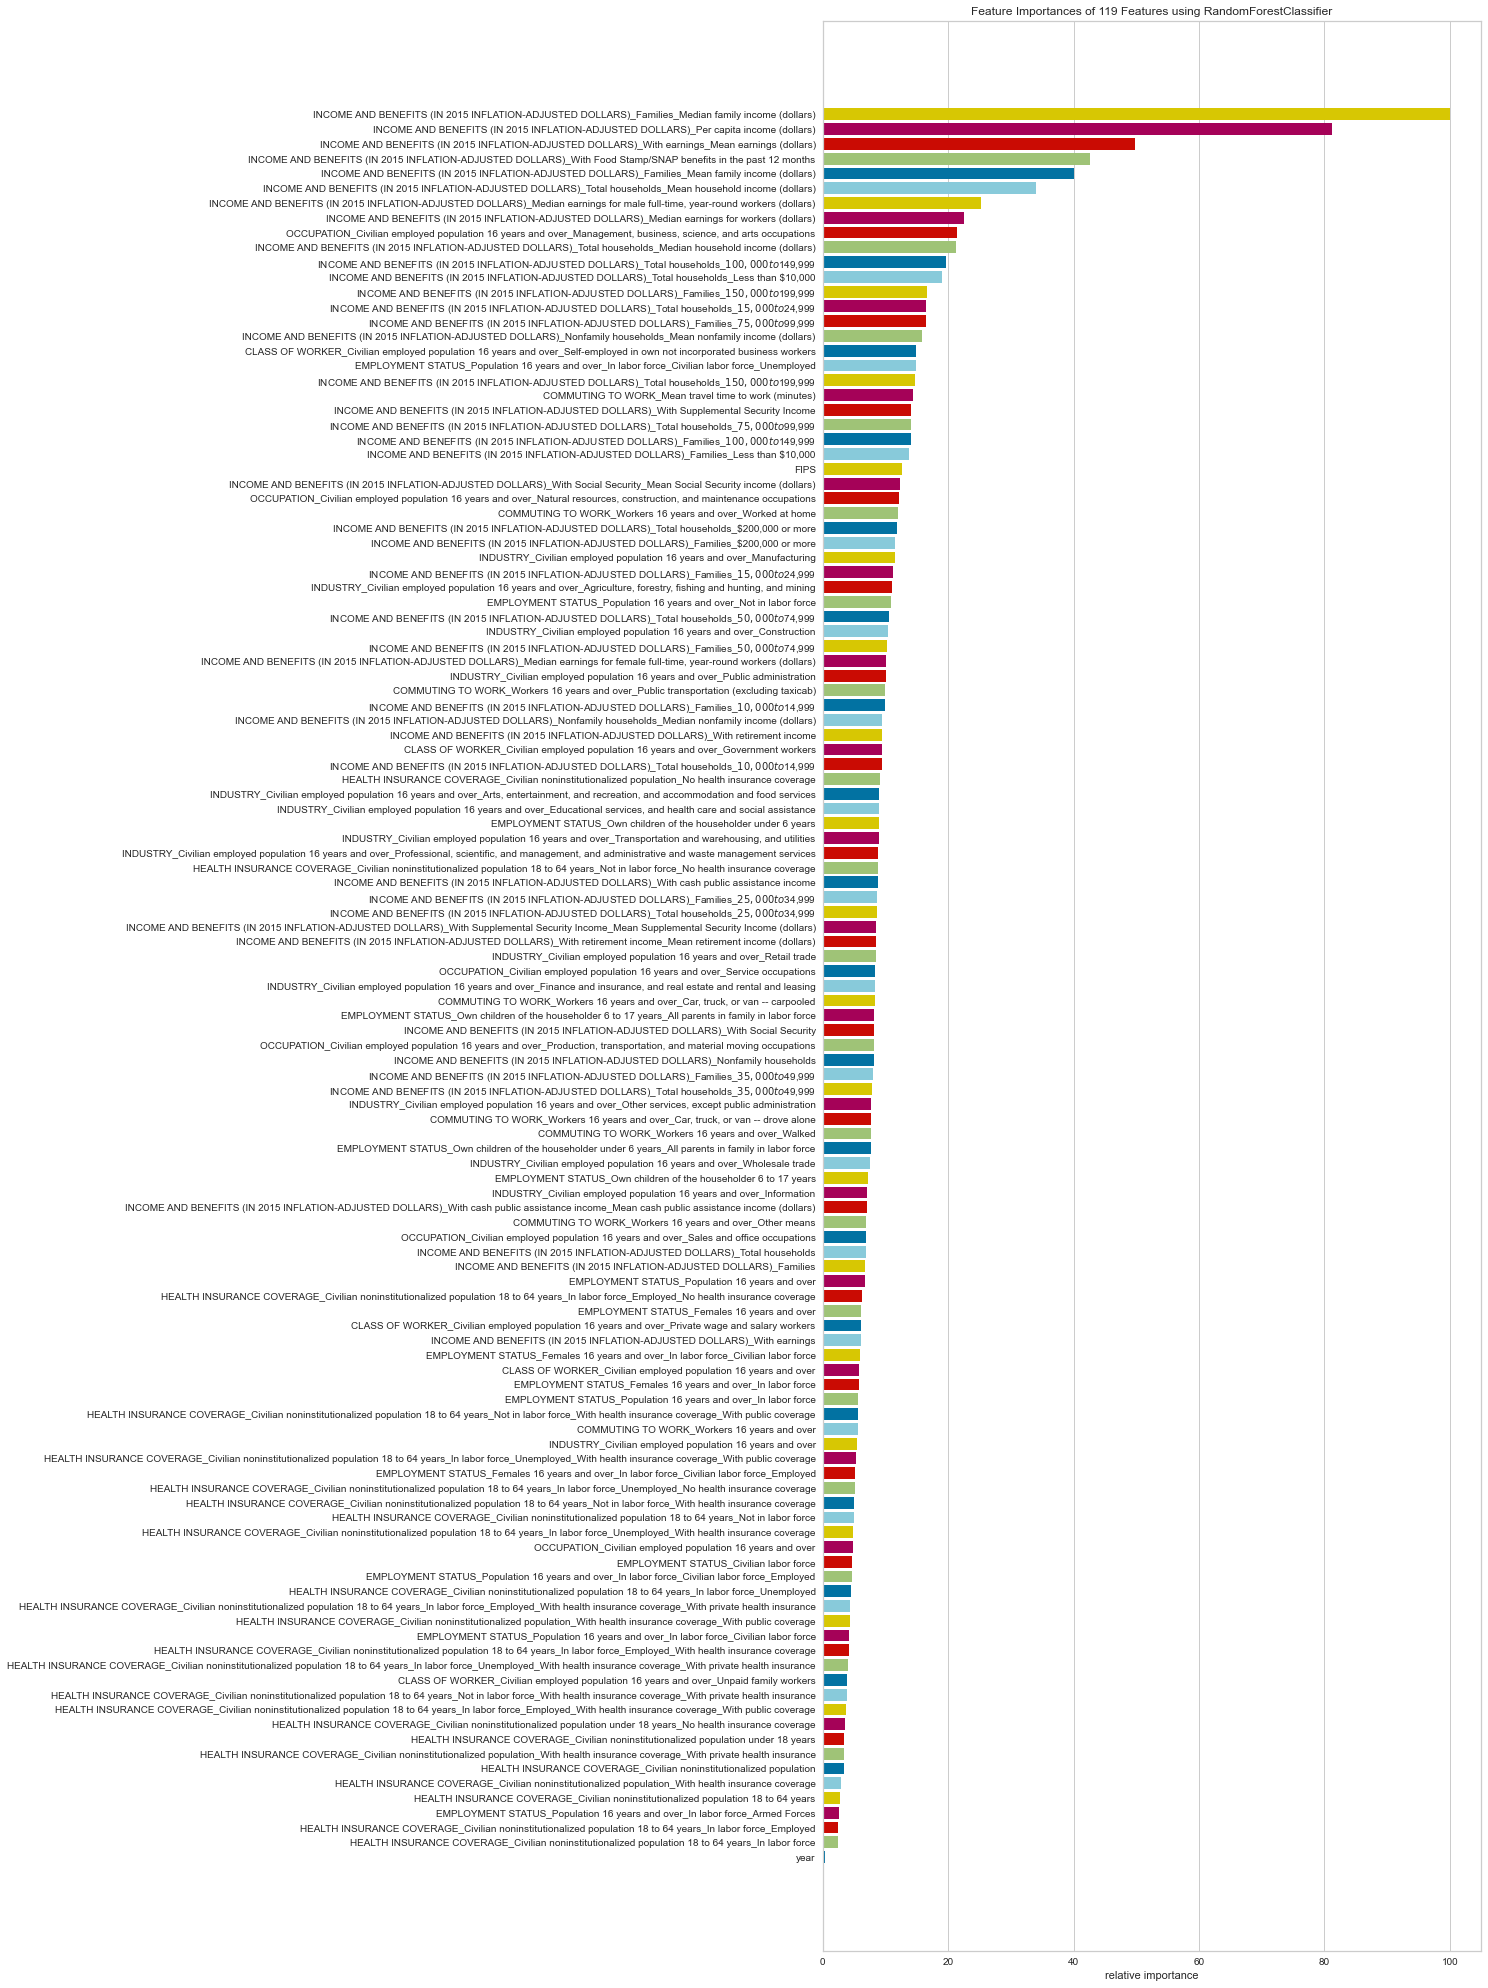

<AxesSubplot:title={'center':'Feature Importances of 119 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [6]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances

# Load the classification data set
X = est.loc[:, est.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = est['Child Opportunity Levels, overall COI, nationally-normed']

model = RandomForestClassifier(n_estimators=12)
viz = FeatureImportances(model,size=(1500, 2000))
viz.fit(X, y)
viz.show()

## Identify features that are more than 80% correlated
Next, we use the pandas .corr function to identify features that are more than 80% correlated and remove them from the dataset.

In [7]:
corrdf = est.corr()
feats = corrdf.index.to_list()
featscol= corrdf.columns.to_list()
pd.options.display.max_colwidth = 300
newdf = pd.DataFrame(columns=['Feature 1','Feature 2','Value'])
i = 0
for f in feats:
    for c in featscol:
        if f == c: 
            pass
        elif corrdf.loc[f][c] >= 0.8:
            newdf.loc[i] = [f, c, corrdf.loc[f][c]]
            i+=1
newdf.sort_values(['Feature 1', 'Feature 2'], ascending=[True, True],inplace=True)
#delete duplicate values because they are repeated combinations
newdf.drop_duplicates(subset='Value',inplace=True)
newdf

,Feature 1,Feature 2,Value
428,CLASS OF WORKER_Civilian employed population 16 years and over,CLASS OF WORKER_Civilian employed population 16 years and over_Private wage and salary workers,0.985226
420,CLASS OF WORKER_Civilian employed population 16 years and over,COMMUTING TO WORK_Workers 16 years and over,0.994800
421,CLASS OF WORKER_Civilian employed population 16 years and over,"COMMUTING TO WORK_Workers 16 years and over_Car, truck, or van -- drove alone",0.980483
413,CLASS OF WORKER_Civilian employed population 16 years and over,EMPLOYMENT STATUS_Civilian labor force,0.995530
414,CLASS OF WORKER_Civilian employed population 16 years and over,EMPLOYMENT STATUS_Females 16 years and over,0.918616
...,...,...,...
529,INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With earnings,"OCCUPATION_Civilian employed population 16 years and over_Management, business, science, and arts occupations",0.815735
530,INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With earnings,OCCUPATION_Civilian employed population 16 years and over_Sales and office occupations,0.894629
378,INDUSTRY_Civilian employed population 16 years and over_Construction,"OCCUPATION_Civilian employed population 16 years and over_Natural resources, construction, and maintenance occupations",0.861909
393,"INDUSTRY_Civilian employed population 16 years and over_Professional, scientific, and management, and administrative and waste management services","OCCUPATION_Civilian employed population 16 years and over_Management, business, science, and arts occupations",0.830922


In [8]:
est_rmv = pd.read_csv('s3://bleeding-hearts/workingdata/est_overall.csv')
est_rmv.drop(columns=['Unnamed: 0'],inplace=True)
est_rmv = est_rmv.drop(columns=list(set(newdf['Feature 2'])))
print('#/columns in est data:',len(est.columns),'\n','#/columns in est_rmv data:',len(est_rmv.columns), '\n','We removed', len(est.columns)-len(est_rmv.columns),'columns that were more than 80% correlated')

#/columns in est data: 120 
 #/columns in est_rmv data: 64 
 We removed 56 columns that were more than 80% correlated


In [9]:
#save the dataset without highly correlated features to S3
with open('/Volumes/Key/aws_keys.json') as f:
  creds = json.load(f)

def s3upload(name,df):
    x = df.to_csv(None).encode()
    fs = s3fs.S3FileSystem(key=creds['AWSAccessKeyId'], secret=creds['AWSSecretKey'])
    with fs.open('s3://bleeding-hearts/workingdata/' + name + '.csv', 'wb') as f:
        f.write(x)
    print('saved')

#s3upload('est_rmv',est_rmv)

In [10]:
#impute mean values for missing values
means = {}
cols=list(est_rmv)
for c in cols:
    if len(est_rmv) - est_rmv[c].count() > 0:
        means[c] = est_rmv[c].dropna().mean()
est_rmv.fillna(value=means,inplace=True)
#check that there are no more missing values
est_rmv.columns[est_rmv.isnull().any()]
#replace string classes with numbers
num = {
    'Very Low':1,
    'Low':2,
    'Moderate':3,
    'High':4,
    'Very High':5
}
cols=list(est_rmv.columns)

## Run Feature Importances on Reduced Features
**Random Forest**

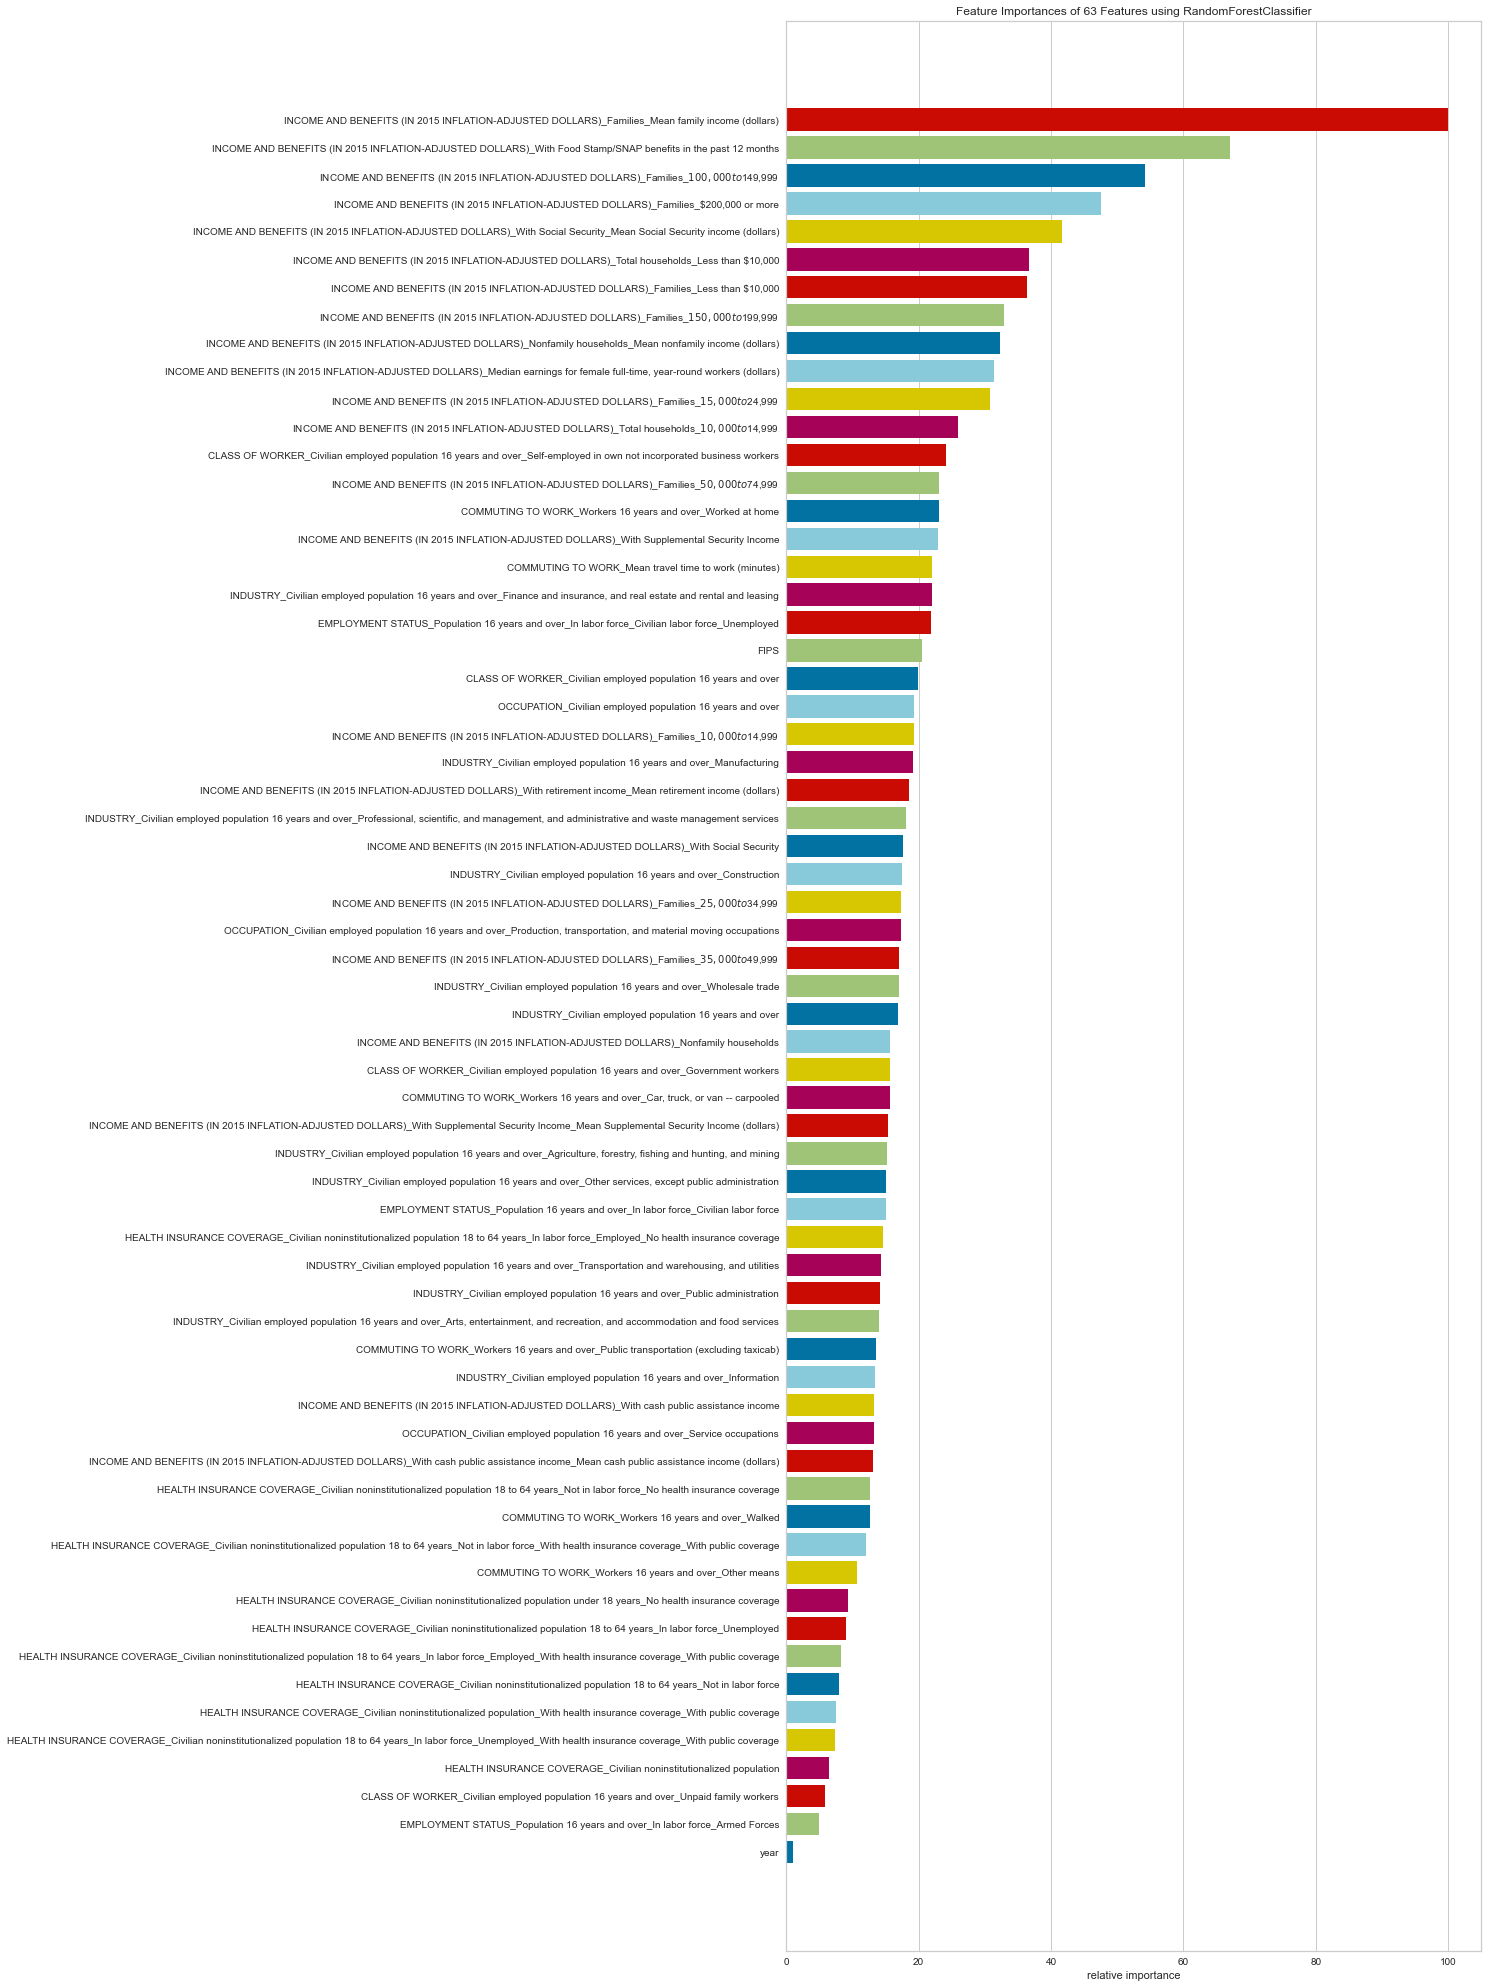

<AxesSubplot:title={'center':'Feature Importances of 63 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [11]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances

# Load the classification data set
X = est_rmv.loc[:, est_rmv.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = est_rmv['Child Opportunity Levels, overall COI, nationally-normed']

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model,size=(1500, 2000))
viz.fit(X, y)
viz.show()

**Gradient Boosting**

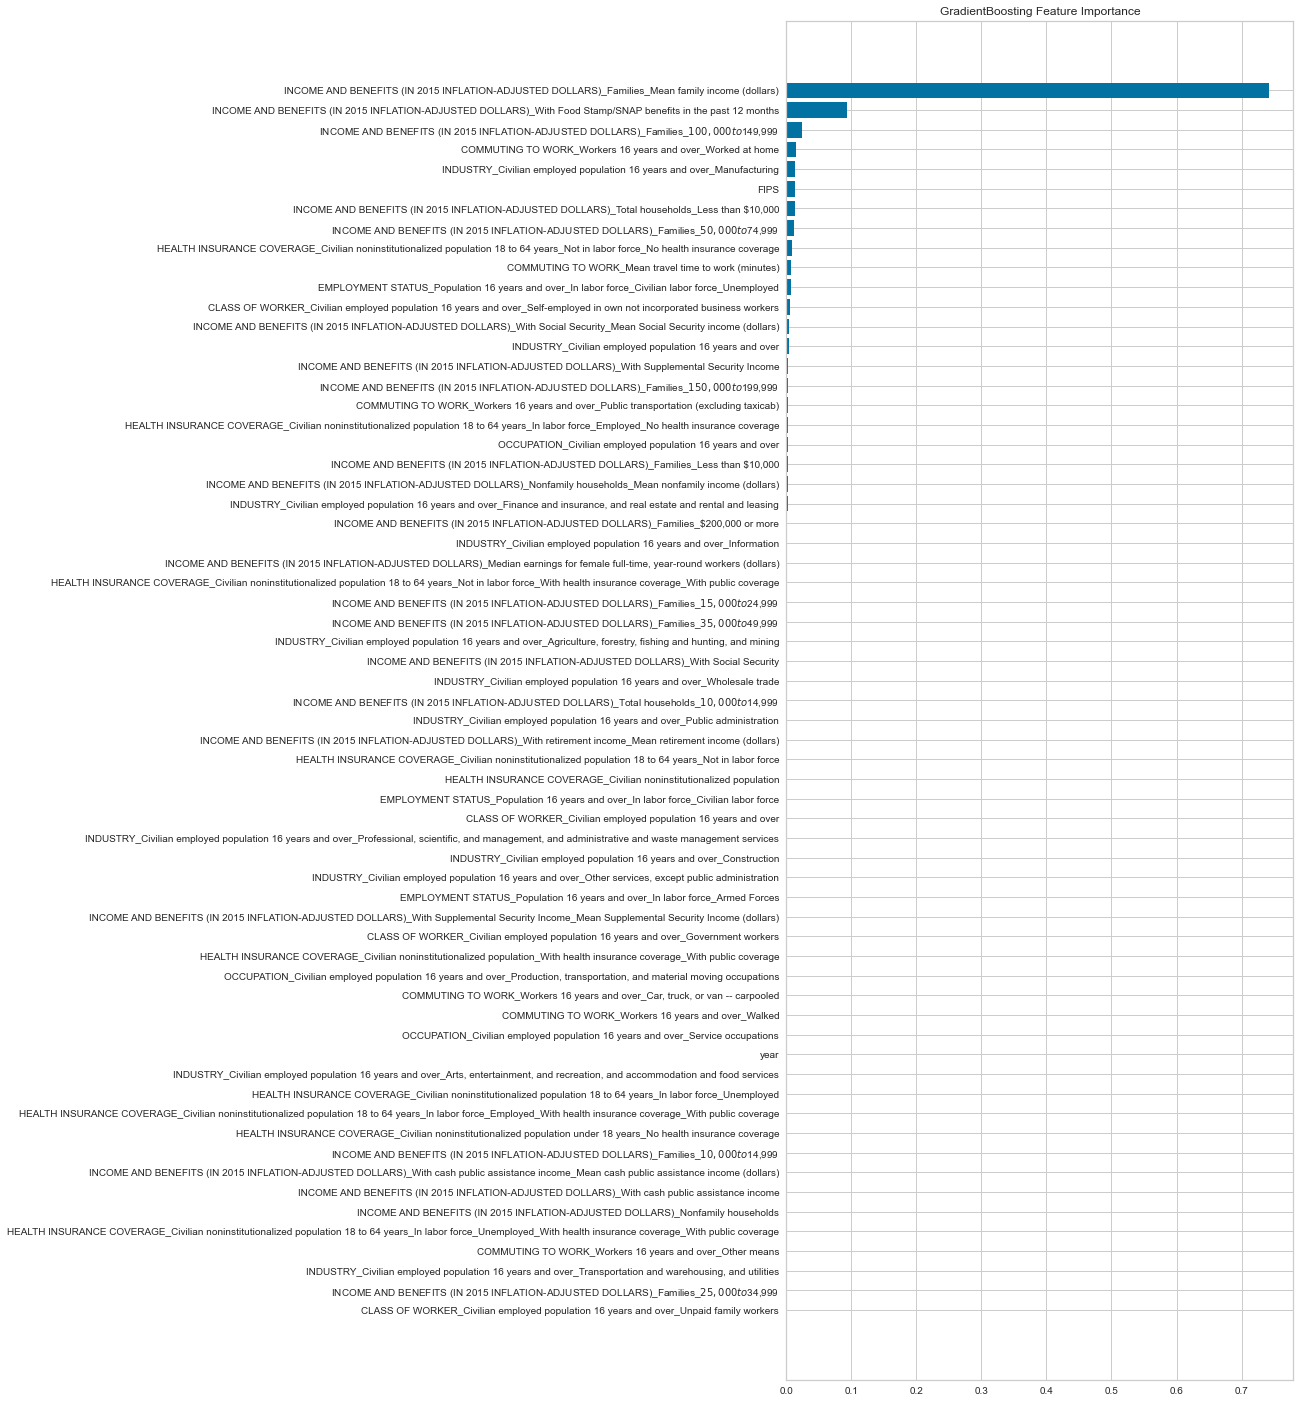

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = est_rmv.loc[:, est_rmv.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = est_rmv['Child Opportunity Levels, overall COI, nationally-normed'].map(num)

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

reg = ensemble.GradientBoostingRegressor()
reg.fit(X_train, y_train)


feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(20,25))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(cols)[sorted_idx])
plt.title('GradientBoosting Feature Importance')
plt.show()

**SVC**

In [ ]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

svm = svm.SVC(kernel='linear')

X = est_rmv.loc[:, est_rmv.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = est_rmv['Child Opportunity Levels, overall COI, nationally-normed']

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

svm.fit(X_train, y_train)
f_importances(svm.coef_, cols)